In [1]:
import os
import imageio as iio
from pathlib import Path
import numpy as np
from glob import glob
import matplotlib.cm as cm
import matplotlib.pyplot as plt

#AIRXD model import
from airxd.mask import MASK
from airxd_cnn.cnn import ARIXD_CNN as cmodel
from airxd.model import ARIXD
from airxd.dataset import Dataset, parse_imctrl

# Troubleshooting

In [13]:
import torch
import torch.nn.functional as F


In [14]:
# Generate a random image for demonstration
image = torch.rand(1, 1, 100, 100)  # Shape: (batch_size, channels, height, width)


In [19]:
# Generate coordinates for the grid, ensuring they stay within image bounds
grid_x = torch.linspace(-0.9, 0.9, 10)  # Values between -1 and 1 (normalized)
grid_y = torch.linspace(-0.9, 0.9, 10)
grid_y, grid_x = torch.meshgrid(grid_y, grid_x)
grid = torch.stack((grid_x, grid_y), dim=-1)  # Shape: (10, 10, 2)

# Reshape the grid to match the image dimensions
grid = grid.view(1, 1, 10, 10, 2).repeat(1, 1, 100, 100, 1)  # Shape: (1, 1, 100, 100, 2)


In [20]:
cropped_images = F.grid_sample(image, grid, mode='bilinear', padding_mode='zeros')

RuntimeError: grid_sampler(): expected 4D input and grid with same number of dimensions, but got input with sizes [1, 1, 100, 100] and grid with sizes [1, 1, 1000, 1000, 2]

In [1]:
import einops
import torch
import numpy as np

x = torch.rand((10,1,2880,2880))
y = torch.rand((10,1,2880,2880))

In [2]:
import qlty
from qlty import qlty2D

quilt = qlty2D.NCYXQuilt(X=2880,
                         Y=2880,
                         window=(256,256),
                         step=(128,128),
                         border=(64,64),
                         border_weight=0)

In [3]:
x_bits, y_bits = quilt.unstitch_data_pair(x,y)
print("x shape: ",x.shape)
print("y shape: ",y.shape)
print("x_bits shape:", x_bits.shape)
print("y_bits shape:", y_bits.shape)

x shape:  torch.Size([10, 1, 2880, 2880])
y shape:  torch.Size([10, 1, 2880, 2880])
x_bits shape: torch.Size([4840, 1, 256, 256])
y_bits shape: torch.Size([4840, 1, 256, 256])


In [5]:
#Calculate size of x_bits in megabytes
x_bits.shape[0] * x_bits.itemsize / 1e6 #size of x_bits in megabytes

tensor([[0.4766, 0.1971, 0.0431,  ..., 0.0057, 0.7003, 0.9482],
        [0.0251, 0.6186, 0.1771,  ..., 0.4878, 0.6418, 0.1646],
        [0.0487, 0.5537, 0.1498,  ..., 0.0083, 0.1717, 0.7881],
        ...,
        [0.3662, 0.4824, 0.6656,  ..., 0.0815, 0.6366, 0.3154],
        [0.0837, 0.2683, 0.6037,  ..., 0.2525, 0.7902, 0.2660],
        [0.3648, 0.0858, 0.0980,  ..., 0.9895, 0.4325, 0.4008]])

In [4]:
y_mock = torch.rand( (8410,17,16,16))

In [5]:
y_stiched, weights = quilt.stitch(y_mock)

In [10]:
weights[0][0]

tensor(1.0000e-08)

In [5]:
import skimage
from skimage.morphology import disk
from skimage.filters import rank
from skimage import exposure

def normalize(image):
        footprint = disk(32)
        img = np.log(np.abs(image) - np.min(image) + 1e-7)
        p2, p98 = np.percentile(img, (2, 98))
        img = exposure.rescale_intensity(img, in_range=(p2, p98))
        img = skimage.util.img_as_ubyte(img)
        img_eq = rank.equalize(img, footprint)
        img_eq = img_eq.astype(float)/256.0
        return img_eq  

In [ ]:
from PIL import Image

In [3]:
import time

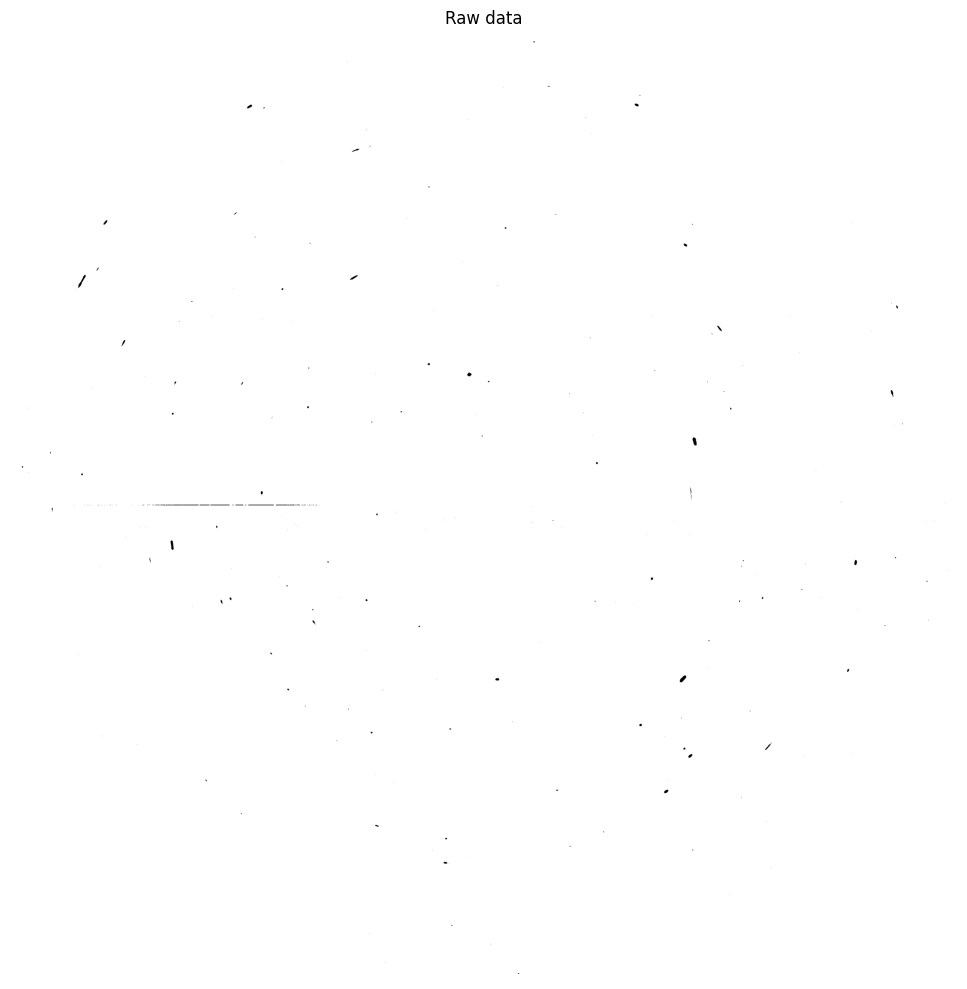

Time to load image: 0.013443946838378906 seconds


In [13]:
temp_path = 'data/Nickel/masks/'
images = glob(temp_path + '*.tif')

i = 0

#Time the code below
start = time.time()

test_im = iio.v2.volread(images[i])
#test_im_norm = normalize(test_im)


#Stop recording time
end = time.time()
#Plot positions of all nonzero elements in test_im
plt.figure(figsize=(10,10))
#If plotting regular images use vmin=0, vmax=15000
plt.imshow(test_im, cmap='binary', origin='lower',)
plt.title('Raw data')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f'Time to load image: {end-start} seconds')

In [12]:
#Get memory size of test_im
test_im.size * test_im.itemsize / 1e6 #size of test_im in megabytes

33.1776

# Create/load a specific dataset

Here, we'll be utilizing the auto-masking process developed in __ to automatically generate labelled/segmented data for artifact identification.


In [ ]:
Samples = glob('data/*')
mask_folder = 'masks'

for path_to_sample in Samples:

    path_to_sample = path_to_sample + '/'

    if not os.path.isdir(path_to_sample + mask_folder):
        #Grabbing imctrl file and parsing its contents. If no imctrl file exists, skip this
        try:
            imctrl_file = glob(path_to_sample + '*.imctrl')[0]
        except:
            continue
        else:
            #Assign controls
            controls = parse_imctrl(imctrl_file)

            #Creating mask, need to specify image size here
            #This MASK function was developed from a previous publication by Yanxon et al.
            mask = MASK(controls=controls, shape=(2880,2880))

            #Creating mask directory
            os.mkdir(path_to_sample + mask_folder)
            paths = glob(path_to_sample + '*.tif')

            #Generate masked image for each sample image and save it in a mask subdirectory for a specific dataset
            for path in paths:
                image_name = path.split('/')[-1][:-4]
                image = iio.v2.volread(path)
                result = mask.AutoSpotMask(image, esdmul=7.0)
                iio.v2.imwrite(path_to_sample + f'{mask_folder}/{image_name}_mask.tif', result)


# Creating dataset/dataloaders for training

First we'll apply a normalization process to the images and save it as a separate image. We don't apply this as part of a transformation pipeline because we normalize an entire powder diffraction images (2880 x 2800 pixels), while the input windows (256 x 256 pixels) used for training and inference are not each normalized separately. 

This way we perform the normalization once for every image independently, and we can then dice up the image however we choose.

In [2]:
import re
import airxd_cnn
from airxd_cnn.transforms import powder_normalize

classes = [f for f in glob('data/Nickel')]
masks = [f for f in glob('data/*/masks/*.tif')]



In [4]:
#Normalize images within each class folder and save in separate subfolder
normalized_dir = 'data/normalized'
if not os.path.isdir(normalized_dir):
    os.mkdir(normalized_dir)

for path_to_class in classes:
    path_identifier = path_to_class + '/' + '*.tif'
    sample_paths = glob(path_identifier)

    #Load images, normalize and save them
    for path in sample_paths:
        image_name = path.split('/')[-1][:-4]
        image = iio.v2.volread(path)
        image_norm = powder_normalize(image)
        iio.v2.imwrite(normalized_dir + f'/{image_name}_norm.tif', image_norm)
        



Here we'll grab put all relevant tif files into a dataset

In [14]:
#Create dataset object from data files
Samples = [f for f in glob('data/*') if "Nickel" in f]
dataset = Dataset(n=len(Samples))

#Grab all tif files from directories in Samples
dataset.get_data(Samples, label_ext = '.tif')



In [ ]:
#Check how much available memory exists 
#Note: This is not the same as the amount of memory used by the dataset
#This is the amount of memory available for the dataset to use


In [15]:
i = 0
dataset.images[i].size * dataset.images[i].itemsize / 1e6 #size of dataset images in megabytes

729.9072

Next, we need to define our model parameters. This includes quilter params (for stitching pytorch tensors), and model params (for the UNet).

The purpose of a quilter here is to cut up a large tensor into smaller overlapping pieces which can then be fed into a GPU card (in case there are memory limitations).

Here, we have:<br>
*N* = window size (of a patch)<br>
*M* = Step size (how much the patch/window is moved)<br>
*B* = Border size (Border of window which is multiplied by border weight)<br>

E.g. A window size of 256, step size of 128, with a border size of 32 means that
we take patches of size (256-64 = 192) x 192. These 192 x 192 blocks overlap with one another, since we only take a step of size 128 when moving to a new patch.

In [ ]:
#Define quilter hyperparams
#Quilter takes a large tensor and cuts it up into smaller pieces in case the whole tensor
#does not fit 
N = 256 #Patch size
M = N // 2
B = M // 4

#Define quilter params
quilter_params = {'Y': 2880, 'X': 2880,
                  'window': (N, N),
                  'step': (M, M),
                  'border': (B, B),
                  'border_weight': 0}

#Define TUNet params (from dlsia)
model_params = {'image_shape': (2880, 2880),
                'in_channels': 1,
                'out_channels': 2,
                'base_channels': 8,
                'growth_rate': 2,
                'depth': 4}


Next, we need to define training params as well as define the model

In [ ]:
#Training parameters
epoch = 10
batch_size = 50
lr_rate = 1e-2

model = cmodel(quilter_params, model_params, device = 'cuda:0')

In [ ]:
import random

In [ ]:
dataset.images

In [ ]:
#Train
model.train(dataset, include_data={0: [0],
                                   1: [0],
                                   2: [0],
                                   3: [0],
                                   4: [0],
                                   5: [0]},
            epoch=epoch,
            batch_size=batch_size,
            lr_rate=lr_rate)

model.save('models/test_model.pt')